## Denoise Validation


In [1]:
import scanpy as sc
from scprint import scPrint
from scdataloader import Preprocessor

import numpy as np
import anndata as ad

from scprint.tasks import Denoiser, withknn
from scdataloader.utils import downsample_profile
from scipy.stats import spearmanr

%load_ext autoreload
%autoreload 2

import torch
torch.set_float32_matmul_precision('medium')

/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/bitsandbytes/cextension.py:31: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cpu.so: undefined symbol: cadam32bit_grad_fp32
💡 connected lamindb: jkobject/scprint


In [ ]:
# model = scPrint.load_from_checkpoint('../../data/tensorboard/scprint_test/urxxwu28/checkpoints/epoch=0-step=20000.ckpt') #chocolate-surf-8
# '../../data/main/gene_embeddings.parquet')
model = scPrint.load_from_checkpoint(
    '../data/temp/o2uniqsx/epoch=18-step=133000.ckpt', precpt_gene_emb=None)
# ../../data/temp/epoch=4-step=12500.ckpt latest model maestro (fortuitous laugther)
# ../../data/logs/scprint_test/f4vao230/checkpoints/epoch=10-step=27500.ckpt looked good as a training run (vermlillion noodle)
# d1792z9k/epoch=3-step=10000.ckpt
# '../../data/temp/d1792z9k/epoch=3-step=10000.ckpt'
# '../../data/temp/6q3dzi3x/epoch=3-step=10000.ckpt'
# '../../data/temp/grsachbg/epoch=2-step=15000.ckpt'
# ../../data/temp/za9mg1w3/epoch=7-step=40000.ckpt
# post debug
# "../lightning_logs/version_14/checkpoints/epoch=1-step=5000.ckpt"

RuntimeError caught: scPrint is not attached to a `Trainer`.



In [ ]:
#'/pasteur/appa/scratch/jkalfon/scprint/.lamindb/R4ZHoQegxXdSFNFY5LGe.h5ad', '/pasteur/appa/scratch/jkalfon/scprint/.lamindb/SHV11AEetZOms4Wh7Ehb.h5ad', '/pasteur/appa/scratch/jkalfon/scprint/.lamindb/V6DPJx8rP3wWRQ43LMHb.h5ad', '/pasteur/appa/scratch/jkalfon/scprint/.lamindb/Gz5G2ETTEuuRDgwm7brA.h5ad', '/pasteur/appa/scratch/jkalfon/scprint/.lamindb/YyBdEsN89p2aF4xJY1CW.h5ad', '/pasteur/appa/scratch/jkalfon/scprint/.lamindb/SO5yBTUDBgkAmz0QbG8K.h5ad', '/pasteur/appa/scratch/jkalfon/scprint/.lamindb/r4iCehg3Tw5IbCLiCIbl.h5ad', '/pasteur/appa/scratch/jkalfon/scprint/.lamindb/SqvXr3i3PGXM8toXzUf9.h5ad', '/pasteur/appa/scratch/jkalfon/scprint/.lamindb/REIyQZE6OMZm1S3W2Dxi.h5ad', '/pasteur/appa/scratch/jkalfon/scprint/.lamindb/rYZ7gs0E0cqPOLONC8ia.h5ad', '/pasteur/appa/scratch/jkalfon/scprint/.lamindb/FcwMDDbAQPNYIjcYNxoc.h5ad', '/pasteur/appa/scratch/jkalfon/scprint/.lamindb/fvU5BAMJrm7vrgDmZM0z.h5ad', '/pasteur/appa/scratch/jkalfon/scprint/.lamindb/gNNpgpo6gATjuxTE7CCp.h5ad'

In [ ]:
adata = sc.read_h5ad('/home/ml4ig1/scprint/.lamindb/gNNpgpo6gATjuxTE7CCp.h5ad')
adata.layers['true'] = adata.X.copy()
adata

AnnData object with n_obs × n_vars = 51370 × 70116
    obs: 'biosample_id', 'donor_id', 'cell_type_ontology_term_id', 'organism_ontology_term_id', 'disease_ontology_term_id', 'tissue_ontology_term_id', 'assay_ontology_term_id', 'cell_type__custom', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'suspension_type', 'is_primary_data', 'age', 'self_reported_ethnicity_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'cell_culture', 'nnz', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier'
    var: 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'uid', 'symbol', 'ncbi_gene_ids', 'biotype', 'desc

In [ ]:
adata.obs.cell_type.value_counts()

In [5]:
denoise = Denoiser(
    model,
    batch_size=40,
    max_len=4000,
    plot_corr_size=1000,
    doplot=False,
    predict_depth_mult=10,
    downsample = 0.7,
    how="most var"
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [6]:
metrics, idx, genes, expr = denoise(adata)
metrics

4000


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/torch/utils/tensorboard/__init__.py:6: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  ) < LooseVersion("1.15"):
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

adding on disk
AnnData object with n_obs × n_vars = 1000 × 512
    obs: 'pred_cell_type_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id'


{'reco2noisy': 0.7433281635559387,
 'reco2full': 0.5517534225091637,
 'noisy2full': 0.37474688129870615}

In [ ]:
denoise = Denoiser(
    model,
    batch_size=40,
    max_len=2200,
    plot_corr_size=1000,
    doplot=False,
    predict_depth_mult=10,
    downsample = 0.7,
    how="random expr"
)
metrics, idx, genes, expr = denoise(adata)
metrics

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

adding on disk

AnnData object with n_obs × n_vars = 1000 × 512
    obs: 'pred_cell_type_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id'


In [ ]:
genes = torch.load('../../scPRINT/data/temp/vbd8bavn/epoch=17-step=90000.ckpt')['hyper_parameters']['genes']
sc.pp.highly_variable_genes(
    adata, flavor="seurat_v3", n_top_genes=4000, span=0.99)

In [ ]:
adata.X = downsample_profile(torch.Tensor(adata.X.toarray()), 0.7)
random_indices = np.random.randint(
    low=0, high=adata.shape[0], size=2_000
)
denoised_adata = sc.external.pp.magic(adata[random_indices, adata.var.index.isin(genes) & adata.var.highly_variable], copy=True, n_jobs=20, solver='approximate')

In [ ]:
reco = denoised_adata.X
true = adata[:,  adata.var.index.isin(genes) & adata.var.highly_variable].layers['true'].toarray()
noisy = adata[:,  adata.var.index.isin(genes) & adata.var.highly_variable].X
corr_coef, p_value = spearmanr(
    np.vstack(
        [reco[true != 0], noisy[true != 0], true[true != 0]]).T
)
{
    "reco2noisy": corr_coef[0, 1],
    "reco2full": corr_coef[0, 2],
    "noisy2full": corr_coef[1, 2],
}

{'reco2noisy': 0.28484244108328105,
 'reco2full': 0.6367213953972071,
 'noisy2full': 0.3658772110965199}

In [ ]:
denoised_adata = sc.external.pp.magic(adata[adata.obs.cell_type=="microglial cell",  adata.var.index.isin(genes)], knn=10, n_jobs=20, solver='approximate', copy=True)

/home/ml4ig1/.local/lib/python3.10/site-packages/magic/magic.py:650: DeprecationWarning: Call to deprecated method task. (Use TaskLogger.log_task instead) -- Deprecated since version 1.1.0.
  with _logger.task("MAGIC"):
/home/ml4ig1/.local/lib/python3.10/site-packages/magic/magic.py:381: DeprecationWarning: Call to deprecated method info. (Use TaskLogger.log_info instead) -- Deprecated since version 1.1.0.
  _logger.info(
/home/ml4ig1/.local/lib/python3.10/site-packages/magic/magic.py:436: DeprecationWarning: Call to deprecated method task. (Use TaskLogger.log_task instead) -- Deprecated since version 1.1.0.
  with _logger.task("graph and diffusion operator"):
/home/ml4ig1/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 100 dimensions on data with min(n_samples, n_features) = 10
  warnings.warn(
/home/ml4ig1/.local/lib/python3.10/site-packages/magic/magic.py:586: DeprecationWarning: Call to deprecated method warning. (Use TaskLogger.log

  Running MAGIC with `solver='exact'` on 23149-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.


/home/ml4ig1/.local/lib/python3.10/site-packages/magic/magic.py:748: DeprecationWarning: Call to deprecated method task. (Use TaskLogger.log_task instead) -- Deprecated since version 1.1.0.
  with _logger.task("imputation"):


In [ ]:
reco = denoised_adata.X
true = adata[adata.obs.cell_type=="microglial cell",  adata.var.index.isin(genes)].layers['true'].toarray()
noisy = adata[adata.obs.cell_type=="microglial cell",  adata.var.index.isin(genes)].X

In [12]:
metrics

{'reco2noisy': 0.8116404746787907,
 'reco2full': 0.4799334600140964,
 'noisy2full': 0.3477227116971942}

In [11]:
metrics, idx, genes, expr = denoise(adata[adata.obs.cell_type=="microglial cell"])
metrics

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

{'reco2noisy': 0.8472227845343375,
 'reco2full': 0.25931822794527054,
 'noisy2full': 0.20078609731401278}

In [ ]:
metrics

{'reco2noisy': 0.8606367369944957,
 'reco2full': 0.21436212835201177,
 'noisy2full': 0.16335074487027934}

In [131]:
metrics, idx, genes, expr = denoise(adata)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

adding on disk
AnnData object with n_obs × n_vars = 1000 × 256
    obs: 'pred_cell_type_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id'


/home/ml4ig1/Documents code/scPRINT/scprint/tasks/denoise.py:146: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  "reco2full": corr_coef[0, 2],


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 2, the array at index 0 has size 2000 and the array at index 2 has size 1

In [115]:
noisy = np.loadtxt("collator_output.txt")

In [117]:
reco = expr.cpu().numpy()

In [118]:
subadata = adata[adata.obs.cell_type_ontology_term_id=="CL:0000650"].copy()
true = np.vstack([subadata[i,adata.var.index.get_indexer(np.array(model.genes)[val])].X.copy() for i, val in enumerate(genes.cpu().numpy())])

In [123]:
corr_coef, p_value = spearmanr(
    np.vstack(
        [reco[true != 0], noisy[true != 0], true[true != 0]]).T
)
{
    "reco2noisy": corr_coef[0, 1],
    "reco2full": corr_coef[0, 2],
    "noisy2full": corr_coef[1, 2],
}

{'reco2noisy': 0.8574654113506655,
 'reco2full': 0.2024532574588863,
 'noisy2full': 0.16891531594450604}

In [91]:
idx, genes, expr = denoise(adata[adata.obs.cell_type_ontology_term_id=="CL:0000650"])

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [76]:
denoised_adata = sc.external.pp.magic(adata[adata.obs.cell_type_ontology_term_id=="CL:0000650",  adata.var.index.isin(genes)], knn=3,copy=True)

/home/ml4ig1/.local/lib/python3.10/site-packages/magic/magic.py:650: DeprecationWarning: Call to deprecated method task. (Use TaskLogger.log_task instead) -- Deprecated since version 1.1.0.
  with _logger.task("MAGIC"):
/home/ml4ig1/.local/lib/python3.10/site-packages/magic/magic.py:381: DeprecationWarning: Call to deprecated method info. (Use TaskLogger.log_info instead) -- Deprecated since version 1.1.0.
  _logger.info(
/home/ml4ig1/.local/lib/python3.10/site-packages/magic/magic.py:436: DeprecationWarning: Call to deprecated method task. (Use TaskLogger.log_task instead) -- Deprecated since version 1.1.0.
  with _logger.task("graph and diffusion operator"):
/home/ml4ig1/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 100 dimensions on data with min(n_samples, n_features) = 10
  warnings.warn(
/home/ml4ig1/.local/lib/python3.10/site-packages/magic/magic.py:586: DeprecationWarning: Call to deprecated method warning. (Use TaskLogger.log

  Running MAGIC with `solver='exact'` on 23149-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.


/home/ml4ig1/.local/lib/python3.10/site-packages/magic/magic.py:748: DeprecationWarning: Call to deprecated method task. (Use TaskLogger.log_task instead) -- Deprecated since version 1.1.0.
  with _logger.task("imputation"):


In [78]:
reco = denoised_adata.X
true = adata[adata.obs.cell_type_ontology_term_id=="CL:0000650",  adata.var.index.isin(genes)].layers['true'].toarray()
noisy = adata[adata.obs.cell_type_ontology_term_id=="CL:0000650",  adata.var.index.isin(genes)].X

In [38]:
adata = adata[:, adata.var.index.isin(genes)]
adata.layers['noisy'] = adata.X.copy()
adata.X = expr.cpu().numpy()[:, np.argsort(genes)]

adata = adata[np.isnan(adata.X).sum(1)==0]

In [79]:
corr_coef, p_value = spearmanr(
    np.vstack(
        [reco[true != 0], noisy[true != 0], true[true != 0]]).T
)
{
    "reco2noisy": corr_coef[0, 1],
    "reco2full": corr_coef[0, 2],
    "noisy2full": corr_coef[1, 2],
}

{'reco2noisy': 0.6871504115521909,
 'reco2full': 0.26381030106197584,
 'noisy2full': 0.19871702368664976}

In [44]:
denoised_adata = sc.external.pp.magic(adata, copy=True)

/home/ml4ig1/.local/lib/python3.10/site-packages/magic/magic.py:650: DeprecationWarning: Call to deprecated method task. (Use TaskLogger.log_task instead) -- Deprecated since version 1.1.0.
  with _logger.task("MAGIC"):
/home/ml4ig1/.local/lib/python3.10/site-packages/magic/magic.py:381: DeprecationWarning: Call to deprecated method info. (Use TaskLogger.log_info instead) -- Deprecated since version 1.1.0.
  _logger.info(
/home/ml4ig1/.local/lib/python3.10/site-packages/magic/magic.py:381: DeprecationWarning: Call to deprecated method info. (Use TaskLogger.log_info instead) -- Deprecated since version 1.1.0.
  _logger.info(
/home/ml4ig1/.local/lib/python3.10/site-packages/magic/magic.py:436: DeprecationWarning: Call to deprecated method task. (Use TaskLogger.log_task instead) -- Deprecated since version 1.1.0.
  with _logger.task("graph and diffusion operator"):
/home/ml4ig1/.local/lib/python3.10/site-packages/magic/magic.py:748: DeprecationWarning: Call to deprecated method task. (Use

In [11]:
genes = torch.load('../../scPRINT/data/temp/vbd8bavn/epoch=17-step=90000.ckpt')['hyper_parameters']['genes']
sc.pp.highly_variable_genes(
    adata, flavor="seurat_v3", n_top_genes=4000, span=0.99)
genelist = adata.var.index[adata.var.highly_variable]

In [4]:
denoised_adata = sc.external.pp.magic(adata[:, adata.var.index.isin(genes) & adata.var.index.isin(most_var)], copy=True)

/home/ml4ig1/.local/lib/python3.10/site-packages/magic/magic.py:650: DeprecationWarning: Call to deprecated method task. (Use TaskLogger.log_task instead) -- Deprecated since version 1.1.0.
  with _logger.task("MAGIC"):
/home/ml4ig1/.local/lib/python3.10/site-packages/magic/magic.py:381: DeprecationWarning: Call to deprecated method info. (Use TaskLogger.log_info instead) -- Deprecated since version 1.1.0.
  _logger.info(
/home/ml4ig1/.local/lib/python3.10/site-packages/magic/magic.py:436: DeprecationWarning: Call to deprecated method task. (Use TaskLogger.log_task instead) -- Deprecated since version 1.1.0.
  with _logger.task("graph and diffusion operator"):
/home/ml4ig1/.local/lib/python3.10/site-packages/magic/magic.py:586: DeprecationWarning: Call to deprecated method warning. (Use TaskLogger.log_warning instead) -- Deprecated since version 1.1.0.
  _logger.warning(


  Running MAGIC with `solver='exact'` on 23149-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.


/home/ml4ig1/.local/lib/python3.10/site-packages/magic/magic.py:748: DeprecationWarning: Call to deprecated method task. (Use TaskLogger.log_task instead) -- Deprecated since version 1.1.0.
  with _logger.task("imputation"):


In [14]:
adata = adata[:, adata.var.index.isin(genes)]

In [53]:
reco = adata.X
true = adata.layers['true'].toarray()
noisy = adata.layers['noisy'].toarray()

In [43]:
reco = expr.cpu().numpy()
adata = adata[np.isnan(reco).sum(1)==0]
reco = reco[np.isnan(reco).sum(1)==0]

true = adata.layers['true'].toarray()
noisy = adata.X.toarray()

In [54]:
# both scPRINT and Magic
corr_coef, p_value = spearmanr(
    np.vstack(
        [reco[true != 0], noisy[true != 0], true[true != 0]]).T
)
{
    "reco2noisy": corr_coef[0, 1],
    "reco2full": corr_coef[0, 2],
    "noisy2full": corr_coef[1, 2],
}

{'reco2noisy': 0.057951060159191874,
 'reco2full': 0.2117922075748928,
 'noisy2full': 0.2297673495671155}

In [16]:
corr_coef, p_value = spearmanr(
    np.vstack(
        [reco[true != 0], noisy[true != 0], true[true != 0]]).T
)
{
    "reco2noisy": corr_coef[0, 1],
    "reco2full": corr_coef[0, 2],
    "noisy2full": corr_coef[1, 2],
}

{'reco2noisy': 0.36800841152540487,
 'reco2full': 0.3556968835196204,
 'noisy2full': 0.19007795001249247}

In [53]:
adata = withknn(adata[adata.obs.cell_type_ontology_term_id=="CL:0000650"], seed=42, k=3)

Performing kNN-smoothing v2.1 with k=10, d=10, and dither=0.030...

Step 1/4: Smooth using k=2
	PCA took 1.8 s.
	The fraction of variance explained by the top 10 PCs is 11.0 %.
	Calculating pair-wise distance matrix took 3.9 s.
	Calculating the smoothed expression matrix took 17.7 s.
Step 2/4: Smooth using k=4
	PCA took 1.5 s.
	The fraction of variance explained by the top 10 PCs is 12.3 %.
	Calculating pair-wise distance matrix took 6.4 s.
	Calculating the smoothed expression matrix took 17.2 s.
Step 3/4: Smooth using k=8
	PCA took 0.8 s.
	The fraction of variance explained by the top 10 PCs is 14.1 %.
	Calculating pair-wise distance matrix took 3.9 s.
	Calculating the smoothed expression matrix took 17.9 s.
Step 4/4: Smooth using k=10
	PCA took 0.9 s.
	The fraction of variance explained by the top 10 PCs is 16.3 %.
	Calculating pair-wise distance matrix took 3.6 s.
	Calculating the smoothed expression matrix took 16.8 s.
kNN-smoothing finished in 96.0 s.


In [56]:
reco = adata.layers['denoised']#.toarray()
corr_coef, p_value = spearmanr(
    np.vstack(
        [reco[true != 0], noisy[true != 0], true[true != 0]]).T
)
{
    "reco2noisy": corr_coef[0, 1],
    "reco2full": corr_coef[0, 2],
    "noisy2full": corr_coef[1, 2],
}

{'reco2noisy': 0.4216165277703095,
 'reco2full': 0.3225007565509954,
 'noisy2full': 0.2292481709295109}

In [36]:
0.3225 - 0.2292

0.09330000000000002

In [8]:
adata = adata[:, adata.var.index.isin(denoise.genes)]
adata = adata[adata.X.sum(1)!=0]

In [33]:
noisy = adata.X
true = adata.layers['true'].toarray()

In [29]:
adata = withknn(adata, seed=42, k=10)

Performing kNN-smoothing v2.1 with k=10, d=10, and dither=0.030...

Step 1/4: Smooth using k=2
	PCA took 1.7 s.
	The fraction of variance explained by the top 10 PCs is 9.4 %.
	Calculating pair-wise distance matrix took 3.6 s.
	Calculating the smoothed expression matrix took 16.7 s.
Step 2/4: Smooth using k=4
	PCA took 1.1 s.
	The fraction of variance explained by the top 10 PCs is 10.6 %.
	Calculating pair-wise distance matrix took 3.6 s.
	Calculating the smoothed expression matrix took 17.0 s.
Step 3/4: Smooth using k=8
	PCA took 1.4 s.
	The fraction of variance explained by the top 10 PCs is 12.4 %.
	Calculating pair-wise distance matrix took 3.4 s.
	Calculating the smoothed expression matrix took 16.8 s.
Step 4/4: Smooth using k=10
	PCA took 1.1 s.
	The fraction of variance explained by the top 10 PCs is 15.0 %.
	Calculating pair-wise distance matrix took 3.4 s.
	Calculating the smoothed expression matrix took 16.8 s.
kNN-smoothing finished in 87.8 s.


In [34]:
corr_coef, p_value = spearmanr(
    np.vstack(
        [adata.layers['denoised'][true != 0], noisy[true != 0], true[true != 0]]).T
)
metrics = {
    "reco2noisy": corr_coef[0, 1],
    "reco2full": corr_coef[0, 2],
    "noisy2full": corr_coef[1, 2],
}
metrics

{'reco2noisy': 0.652036398441215,
 'reco2full': 0.3123610682901029,
 'noisy2full': 0.22855248865839778}

In [23]:
model = scPrint.load_from_checkpoint(
    '../data/temp/wli32e2j/last.ckpt', precpt_gene_emb=None)

RuntimeError caught: scPrint is not attached to a `Trainer`.



In [24]:
denoise = Denoiser(
    model,
    batch_size=40,
    max_len=5200,
    plot_corr_size=480,
    doplot=False,
    predict_depth_mult=10,
    downsample=0.7,
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [25]:
denoise(adata)

5200


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

adding on disk
AnnData object with n_obs × n_vars = 480 × 512
    obs: 'pred_cell_type_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id'


{'reco2noisy': 0.8753200521932284,
 'reco2full': 0.27215443493577923,
 'noisy2full': 0.2331829378265318}

In [26]:
# '../../data/main/gene_embeddings.parquet')
model = scPrint.load_from_checkpoint(
    '../data/temp/25eer0xz/epoch=20-step=105000.ckpt', precpt_gene_emb=None)

RuntimeError caught: scPrint is not attached to a `Trainer`.



In [27]:
denoise = Denoiser(
    model,
    batch_size=40,
    max_len=5200,
    plot_corr_size=480,
    doplot=False,
    predict_depth_mult=10,
    downsample=0.7,
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [28]:
denoise(adata)

5200


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

adding on disk
AnnData object with n_obs × n_vars = 480 × 256
    obs: 'pred_cell_type_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id'


{'reco2noisy': 0.8837284045872117,
 'reco2full': 0.2687765891091541,
 'noisy2full': 0.23055543332636377}

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

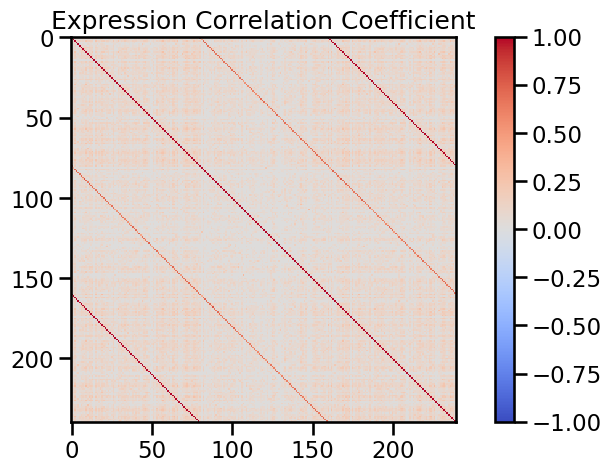

{'reco2noisy': 0.6530767006139186,
 'reco2full': 0.9996833980776685,
 'noisy2full': 0.6433847419595626}

In [22]:
denoise(adata)

/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

adding on disk
AnnData object with n_obs × n_vars = 120 × 512
    obs: 'pred_cell_type_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id'


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in panda

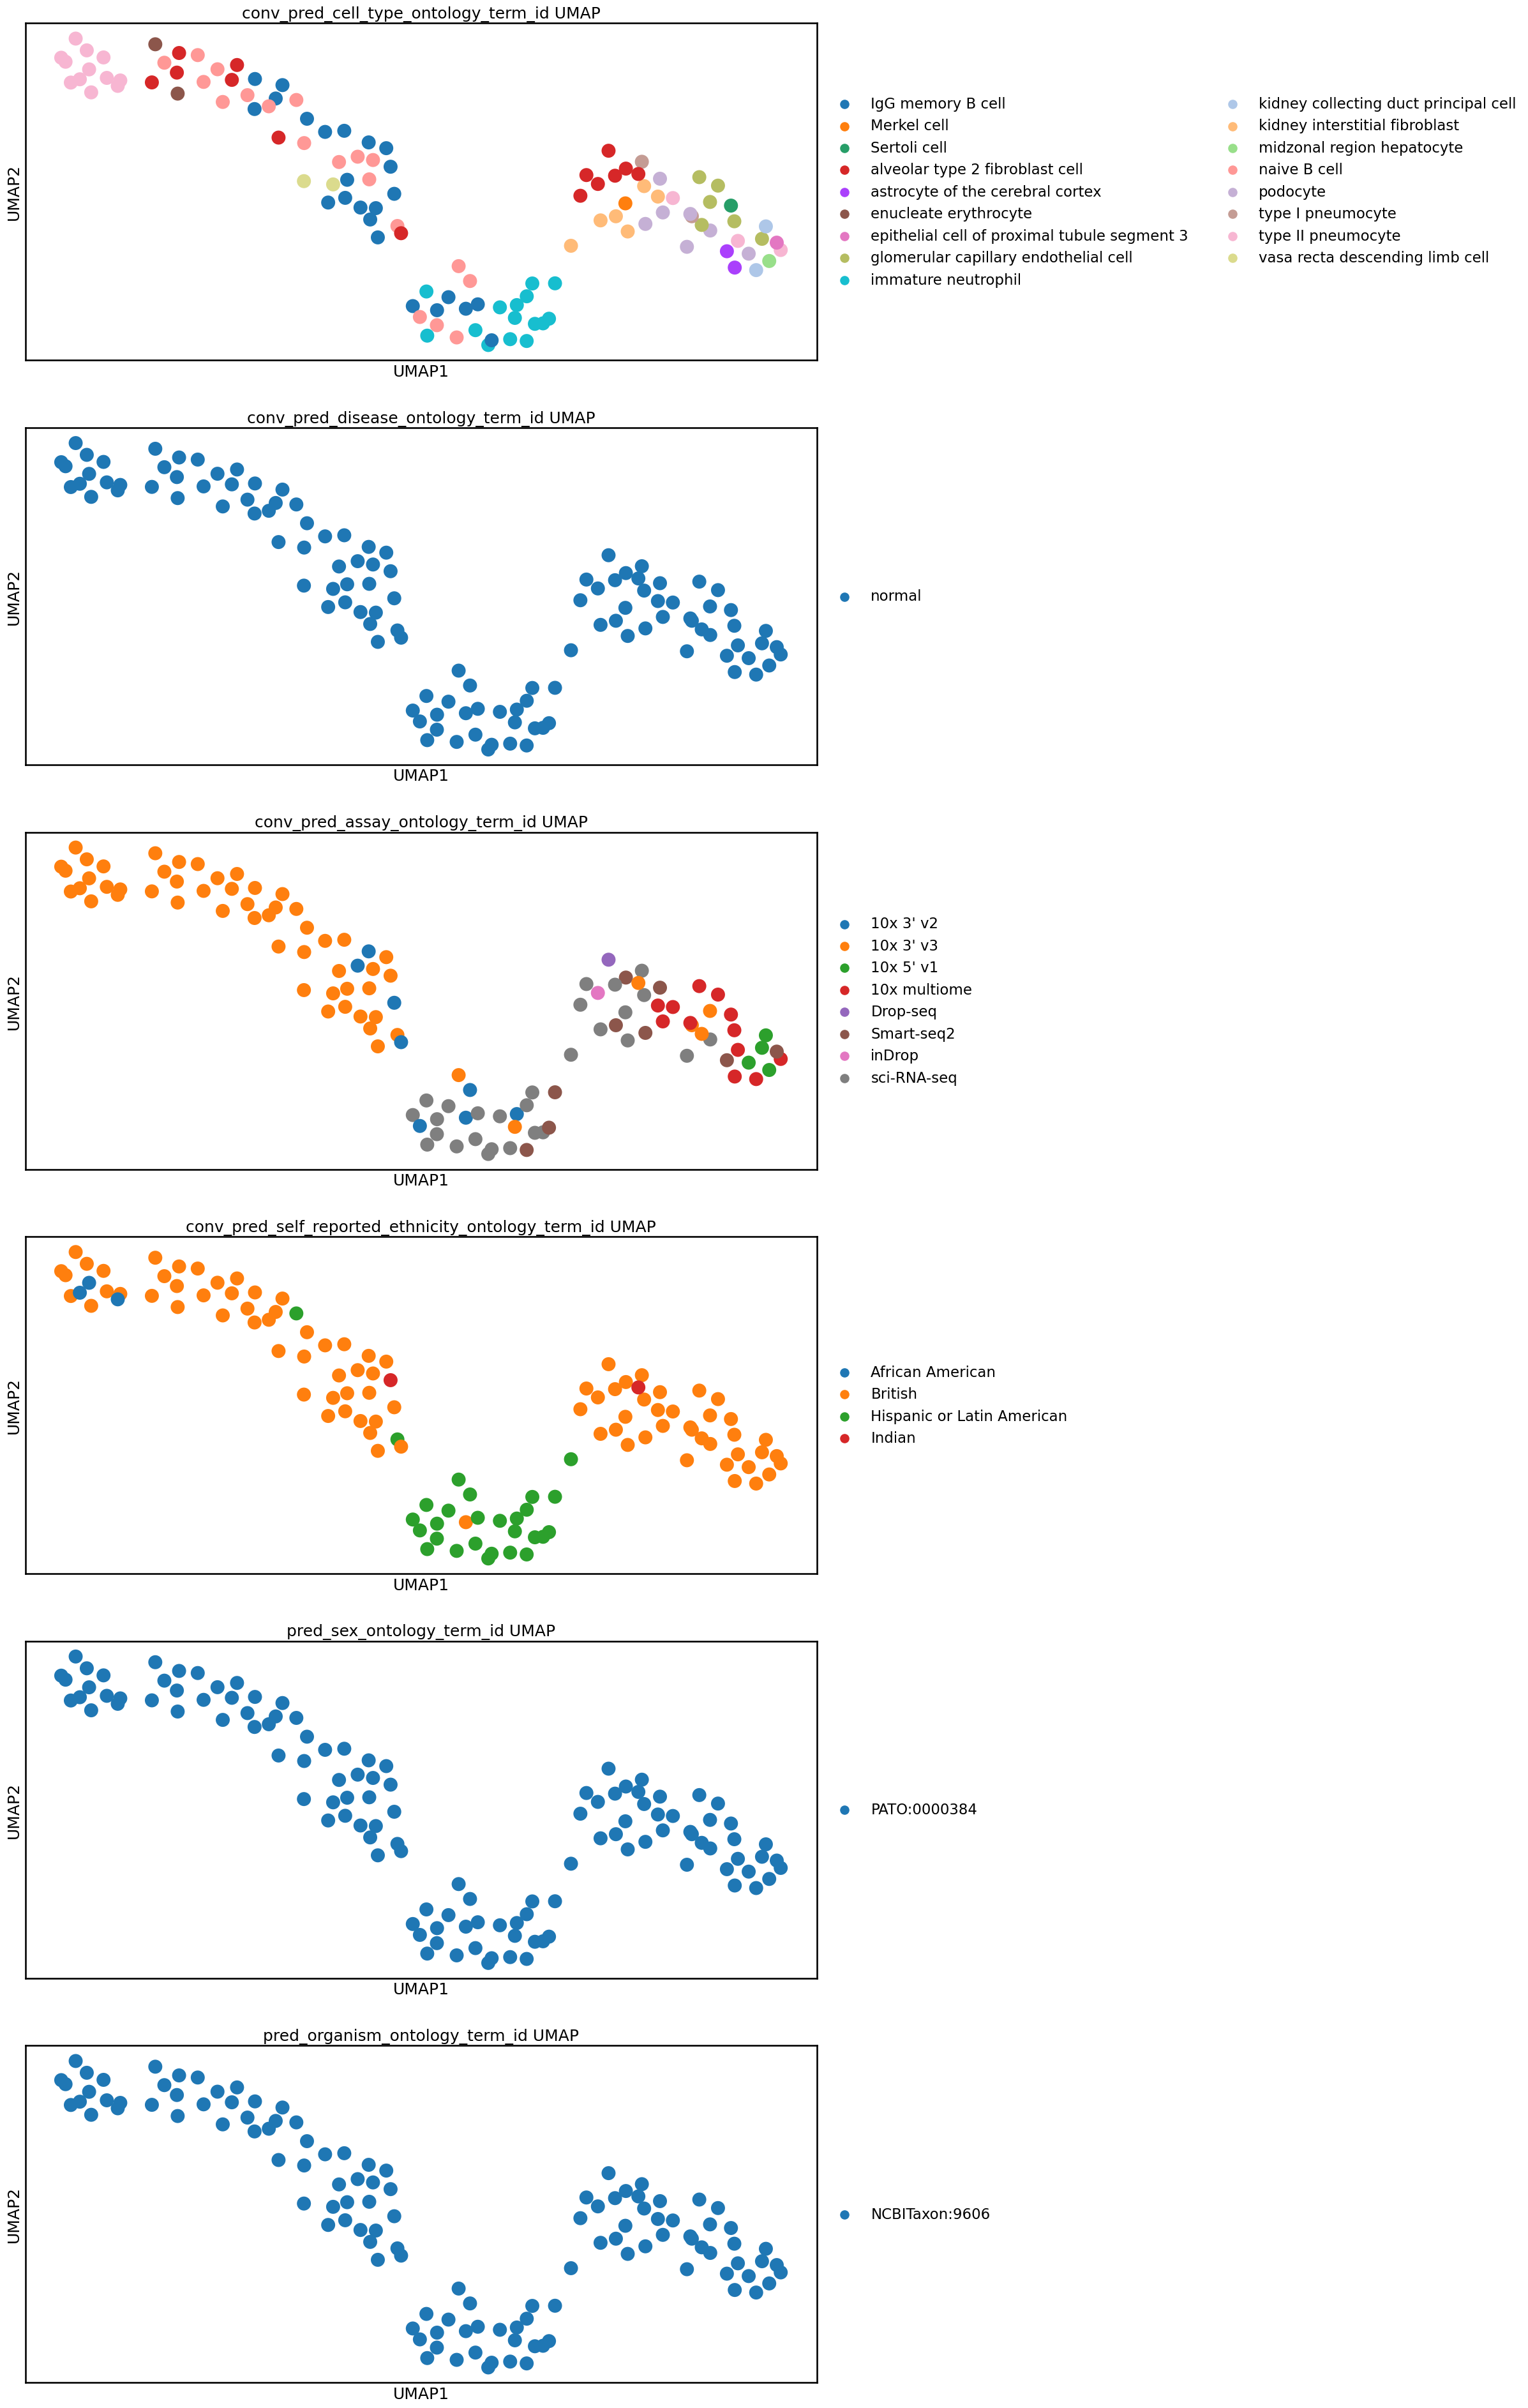

couldn't log to tensorboard
couldn't log to wandb


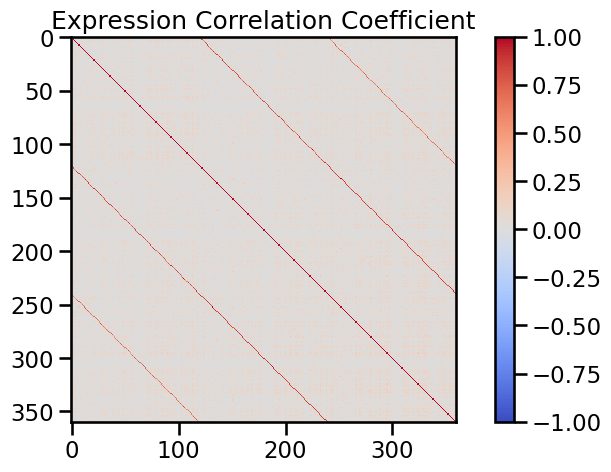

{'reco2noisy': 0.7627226772242612,
 'reco2full': 0.652853653808158,
 'noisy2full': 0.851133289440413}

In [16]:
denoise(adata)

## open problems version


In [3]:
adata = sc.read(
    "data/pancreas_atlas.h5ad",
    backup_url="https://figshare.com/ndownloader/files/24539828",
)
adata = adata[adata.obs.tech == "inDrop1"]

/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_io/specs/registry.py:249: OldFormatWarning: Element '/X' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=get_spec(elem))
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_io/specs/registry.py:249: OldFormatWarning: Element '/X' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=get_spec(elem))
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_io/specs/registry.py:249: OldFormatWarning: Element '/layers' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=get_spec(elem))
/home/ml4ig1/miniconda3/envs/scprint

In [4]:
from scprint.tasks import mse, poisson_nll_loss, split_molecules
import sklearn.metrics

In [ ]:
# here we consider data that has been transformed.. it is not count!
# also we split most of the data in the train
# also we do not set any genes to 0 which goes contrary to what we expect

# also somehow they are comparing to only the 10% of count remaining and not the 100%, it doesn't make sense

In [5]:
train, test = split_molecules(adata.layers['counts'].round().astype(int), 0.9)
is_missing = np.array(train.sum(axis=0) == 0)
true = adata.copy()
true.X = test
adata.layers['counts'] = train
test = test[:, ~is_missing.flatten()]
adata = adata[:, ~is_missing.flatten()]
adata.layers['counts'].sum(1)

In [7]:
adata.obs['organism_ontology_term_id'] = "NCBITaxon:9606"
preprocessor = Preprocessor(subset_hvg=3000, use_layer='counts', is_symbol=True,
                            force_preprocess=True, skip_validate=True, do_postp=False)
nadata = preprocessor(adata.copy())
nadata

Dropping layers:  KeysView(Layers with keys: counts)
checking raw counts
removed 0 non primary cells, 1937 renamining
filtered out 0 cells, 1937 renamining
Removed 0 genes.
startin QC
Seeing 37 outliers (1.91% of total dataset):
done


View of AnnData object with n_obs × n_vars = 1937 × 70116
    obs: 'tech', 'celltype', 'size_factors', 'organism_ontology_term_id', 'nnz', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier'
    var: 'uid', 'symbol', 'ncbi_gene_ids', 'biotype', 'description', 'synonyms', 'organism_id', 'public_source_id', 'created_by_id', 'mt', 'ribo', 'hb', 'organism', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'unseen_genes'

In [10]:
denoise = Denoiser(
    model,
    batch_size=32,
    max_len=15_800,
    plot_corr_size=10_000,
    doplot=False,
    predict_depth_mult=1.2,
    downsample=None,
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [11]:
expr = denoise(nadata)

15800


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/torch/utils/tensorboard/__init__.py:6: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  ) < LooseVersion("1.15"):
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

adding on disk
AnnData object with n_obs × n_vars = 1937 × 256
    obs: 'pred_cell_type_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id'


In [12]:
denoised = ad.AnnData(expr.cpu().numpy(), var=nadata.var.loc[np.array(
    denoise.model.genes)[denoise.model.pos[0].cpu().numpy().astype(int)]])
denoised = denoised[:, denoised.var.symbol.isin(true.var.index)]
loc = true.var.index.isin(denoised.var.symbol)
true = true[:, loc]
train = train[:, loc]
# Ensure expr and adata are aligned by reordering expr to match adata's .var order
denoised = denoised[:, denoised.var.set_index(
    'symbol').index.get_indexer(true.var.index)]
denoised.X = np.maximum(denoised.X - train.astype(float), 0)

In [21]:
# scaling and transformation
target_sum = 1e4

sc.pp.normalize_total(true, target_sum)
sc.pp.log1p(true)

sc.pp.normalize_total(denoised, target_sum)
sc.pp.log1p(denoised)

error_mse = sklearn.metrics.mean_squared_error(
    true.X, denoised.X
)
error_mse

0.43325225

In [26]:
# scaling
initial_sum = train.sum()
target_sum = true.X.sum()
denoised.X = denoised.X * target_sum / initial_sum
error_poisson = poisson_nll_loss(true.X, denoised.X)
error_poisson

0.18706720289045067

# random


In [29]:
trainX = train.copy()
train = true.copy()
train.X = trainX
del trainX

In [31]:
# random:
sc.pp.normalize_total(train, target_sum)
sc.pp.log1p(train)

error_mse = sklearn.metrics.mean_squared_error(
    true.X, train.X
)
error_mse

4.442168

In [32]:
# scaling
initial_sum = train.X.sum()
target_sum = true.X.sum()
train.X = train.X * target_sum / initial_sum
error_poisson = poisson_nll_loss(true.X, train.X)
error_poisson

0.9037052